# Análisis de sentimientos con SLTM y Transformaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-05-22 10:44:10.271245: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-22 10:44:10.284184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747928650.300017   31088 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747928650.305090   31088 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747928650.317087   31088 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
print("Versión de TensorFlow:", tf.__version__)
print("Dispositivos físicos disponibles:", tf.config.list_physical_devices('GPU'))

Versión de TensorFlow: 2.19.0
Dispositivos físicos disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15456432594502355517
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4344709120
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13163788472864356592
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


I0000 00:00:1747928652.467937   31088 gpu_device.cc:2019] Created device /device:GPU:0 with 4143 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tuteggito/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
neg = pd.read_json('../datasets/text/negative.json')
neg["target"] = neg['target'].replace({-1: 0})

In [6]:
pos = pd.read_json('../datasets/text/positive.json')

In [7]:
df = pd.concat([neg, pos], ignore_index=True)
df

,text,target
0,What the hell is going on in the US Senate? Ho...,0
1,“They’re still going to have to go out &amp; p...,0
2,So you’re trying to tell me that Ruben Gallego...,0
3,The day I asked @realDonaldTrump a question ab...,0
4,Premium:\nAudi\nBMW\nMercedes Benz\n\nSub Prem...,0
...,...,...
999995,The animation in this Boondocks episode was CR...,1
999996,Meta launches AI-generated accounts on Faceboo...,1
999997,"Just like anyone, you can never agree with som...",1
999998,🌸 thank u for the raid @Kori_Penguin ! U ARE P...,1


In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1000000 non-null  object
 1   target  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB
None


In [9]:
df.isnull().count()

text      1000000
target    1000000
dtype: int64

In [10]:
print(df['target'].value_counts())

target
0    500000
1    500000
Name: count, dtype: int64


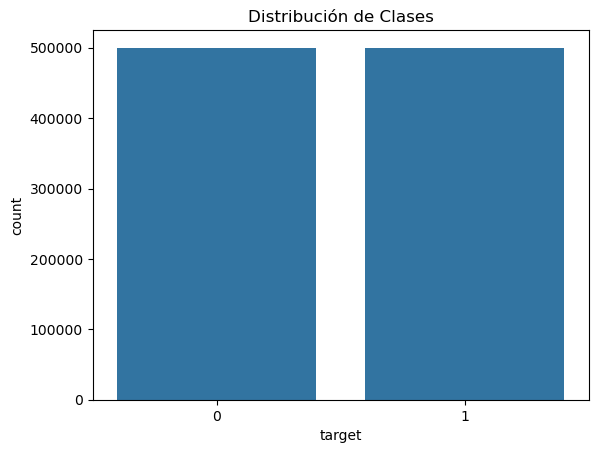

In [11]:
sns.countplot(x='target', data=df)
plt.title('Distribución de Clases')
plt.show()

In [12]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [14]:
df['clean_text'] = df['text'].apply(clean_text)
df['clean_text']

0         hell go us senat hour donald trump win conclus...
1         theyr still go go amp put bullet donald trump ...
2         your tri tell ruben gallego got vote kamala ha...
3         day ask question cant wait ask anoth question ...
4         premium audi bmw merced benz sub premium infin...
                                ...                        
999995                           anim boondock episod crazi
999996    meta launch aigener account facebook instagram...
999997    like anyon never agre someon time that realist...
999998    thank u raid u pawg give pawgger chill stream ...
999999    doherti amp rubi rose sex tape leak drake defi...
Name: clean_text, Length: 1000000, dtype: object

In [15]:
X = df['clean_text']
y = df['target']

In [16]:
max_words = 20000
max_len = 200

In [17]:
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X)

In [18]:
sequences = tokenizer.texts_to_sequences(X)
sequences

[[661,
  14,
  10,
  378,
  281,
  55,
  3,
  81,
  3389,
  2024,
  9,
  3082,
  2581,
  1226,
  2233,
  605,
  49,
  858,
  841,
  56,
  378,
  145,
  491,
  1160,
  276,
  3,
  1722,
  7,
  838,
  3038,
  2317,
  848,
  1618,
  253,
  7600,
  1633,
  1380,
  56,
  1697,
  835,
  1377,
  1651,
  1250,
  12,
  421,
  2944,
  2162,
  1330,
  1408,
  1160,
  705,
  55,
  3,
  49,
  378,
  598,
  177,
  1886,
  2162,
  1330,
  17,
  33,
  2581,
  6,
  282],
 [249, 75, 14, 14, 13, 167, 3960, 55, 3, 1679, 2951, 17, 39, 1341, 1179],
 [118,
  63,
  193,
  4245,
  4091,
  53,
  31,
  126,
  165,
  40,
  75,
  1377,
  378,
  837,
  1681,
  837,
  286,
  8,
  31,
  378,
  1160,
  227,
  704,
  1377,
  65,
  478,
  1349,
  378,
  837,
  2060],
 [19, 214, 513, 84, 277, 214, 132, 513, 323, 36, 4124, 1691, 155, 3],
 [2066,
  11876,
  8780,
  5821,
  7684,
  2953,
  2066,
  7808,
  12143,
  1135,
  8853,
  13304,
  9999,
  4902,
  5609,
  301,
  2242,
  3241,
  1257,
  462,
  1177,
  297,
  1684,
  6

In [19]:
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
pad_sequences

<function keras.src.utils.sequence_utils.pad_sequences(sequences, maxlen=None, dtype='int32', padding='pre', truncating='pre', value=0.0)>

In [20]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

Definir el modelo

In [21]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # salida binaria
])

I0000 00:00:1747928840.621935   31088 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4143 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Compilar y visualizar el modelo

In [22]:
optimizer = Adam(learning_rate=0.01)

In [23]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


Entrenar el modelo

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

# Definir el callback
early_stop = EarlyStopping(
    monitor='val_loss',     # Lo que se va a monitorear ('val_accuracy' también es común)
    patience=3,             # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaura los pesos de la mejor época
)

In [26]:
checkpoint = ModelCheckpoint(
    'model/sentiment/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

In [27]:
# with tf.device('/GPU:0'):
history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=2048, 
    validation_split=0.2,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/100


I0000 00:00:1747928843.581961   33149 cuda_dnn.cc:529] Loaded cuDNN version 90300


313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 112ms/step - accuracy: 0.7626 - loss: 0.4687 - val_accuracy: 0.8728 - val_loss: 0.2952
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 120ms/step - accuracy: 0.8785 - loss: 0.2941 - val_accuracy: 0.8789 - val_loss: 0.2798
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 123ms/step - accuracy: 0.8885 - loss: 0.2664 - val_accuracy: 0.8820 - val_loss: 0.2747
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 140ms/step - accuracy: 0.8963 - loss: 0.2453 - val_accuracy: 0.8850 - val_loss: 0.2769
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step - accuracy: 0.9011 - loss: 0.2317 - val_accuracy: 0.8859 - val_loss: 0.2724
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 57s 182ms/step - accuracy: 0.9074 - loss: 0.2169 - val_accuracy: 0.8864 - val_loss: 0.2766
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 212ms/step - accuracy: 0.9118 - loss: 0.2068 - val_accuracy: 0.8873 - val_loss: 0.2894
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 230ms/step - accuracy: 0.9170 - loss: 0.194

Evaluación

In [28]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - accuracy: 0.8843 - loss: 0.2738
Test Accuracy: 0.8847


In [29]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
y_pred[:, 0]

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step


array([1, 0, 1, ..., 0, 0, 0])

In [30]:
y_pred = pd.Series(y_pred.flatten())
y_pred

0         1
1         0
2         1
3         1
4         0
         ..
199995    0
199996    1
199997    0
199998    0
199999    0
Length: 200000, dtype: int64

In [31]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[89643 10344]
 [12712 87301]]


Probar el modelo con nuevos datos

In [32]:
def predict_sentiment(texts, model, tokenizer, max_len=80):
    # Asegura que sea lista de textos
    if isinstance(texts, str):
        texts = [texts]
        
    # Limpieza
    cleaned_texts = [clean_text(t) for t in texts]
    
    # Tokenización y padding
    sequences = tokenizer.texts_to_sequences(cleaned_texts)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post')
    
    # Predicción
    probs = model.predict(padded)
    preds = (probs > 0.5).astype(int)
    
    return list(zip(texts, preds, probs))

In [33]:
new_texts = [
    "I love this product! It works perfectly.",
    "This is the worst service I've ever had.",
    "Just an average day, nothing special."
]

results = predict_sentiment(new_texts, model, tokenizer)

for text, pred, prob in results:
    sentiment = 'Positive' if pred == 1 else 'Negative'
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {sentiment} (Confidence: {prob[0]:.4f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Text: I love this product! It works perfectly.
Predicted Sentiment: Positive (Confidence: 0.9972)

Text: This is the worst service I've ever had.
Predicted Sentiment: Negative (Confidence: 0.0117)

Text: Just an average day, nothing special.
Predicted Sentiment: Positive (Confidence: 0.5461)



Guardar el modelo

In [34]:
# Crear directorio para guardar el modelo
import os
model_dir = 'model/sentiment'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [35]:
# Guardar el modelo en formato nativo de Keras (.keras)
model.save("model/sentiment/sentiment_model.keras")

Cargar el modelo

In [36]:
from tensorflow.keras.models import load_model
loaded_model = load_model("model/sentiment/sentiment_model.keras")

In [37]:
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,629 (15.45 MB)

 Trainable params: 1,350,209 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,700,420 (10.30 MB)

Guardar el tokenizador

In [38]:
import pickle

with open('model/sentiment/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


Cargar el tokenizador

In [39]:
with open('model/sentiment/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)


In [40]:
tokenizer